In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage


In [2]:
import os
 
os.environ["AZURE_OPENAI_API_KEY"] = "0bf3daeba1814d03b5d62e1da4077478"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openaisk123.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-08-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-4o"

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [4]:
from IPython.display import Image, display
from datetime import datetime

class Agent:
    def __init__(self, model, checkpointer, system_developer="", system_validator="", system_corrector=""):
        self.system_developer = system_developer
        self.system_validator = system_validator
        self.system_corrector = system_corrector

        graph = StateGraph(AgentState)
        
        graph.add_node("developer", self.developer)
        
        graph.add_node("validator", self.validator)  
        graph.add_node("correction", self.correction)

        graph.add_edge("developer", "validator")

     
        graph.add_conditional_edges("validator", lambda state: state["is_valid"], {
        True: END,
        False: "correction"
        })


        graph.add_edge("correction", END)

        graph.set_entry_point("developer")
        self.graph = graph.compile(checkpointer = checkpointer)
        self.model = model


        try:
            display(Image(self.graph.get_graph().draw_mermaid_png()))
        except Exception:
            pass


    # def developer(self, state: AgentState):
    #     messages = state['messages']
    #     print(messages)
    #     print("developer","*" * 50)
    #     if self.system_developer:
    #         messages = [SystemMessage(content=self.system_developer)] + messages
    #     message = self.model.invoke(messages)
    #     # print("developer: ",message)
    #     return {'messages': [message]}

    def developer(self, state: AgentState):
        messages = state['messages']
        print(messages)
        print("developer", "*" * 50)

        # Get current date
        current_date = datetime.now().strftime("%Y-%m-%d")

        # Append the current date as a system-level message
        date_message = SystemMessage(content=f"Today's date is {current_date}.")

        # Prepend system prompt and date
        if self.system_developer:
            messages = [SystemMessage(content=self.system_developer), date_message] + messages
        else:
            messages = [date_message] + messages

        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def validator(self, state: AgentState):
        messages = state.get("messages", [])
        print(messages)

        print("validate","*" * 50)


        if self.system_validator:
            messages = [SystemMessage(content=self.system_validator)] + messages

        message = self.model.invoke(messages)
        response_text = getattr(message, "content", "").lower()

        is_valid = "correctly reflects" in response_text and "no contradictions" in response_text
        res = {"is_valid": is_valid, "messages": [message]}  
        return res



    def correction(self, state: AgentState):
        messages = state['messages']
        print(messages)

        print("correction","*" * 50)

        if self.system_corrector:
            messages = [SystemMessage(content=self.system_corrector)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    


from langchain_openai import AzureChatOpenAI
model = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
)

In [5]:
report_generator_prompt = """
Role: You are a professional report generator with expertise in technical documentation, stakeholder communication, and agile practices. Your task is to **convert any given input into a structured, formal report** suitable for leadership or client consumption.

### **TASK:**  
1. **Analyze the Input**: Review and extract relevant information (e.g., goals, tasks, features, blockers, updates).  
2. **Generate a Professional Report**: Summarize key insights, organize information, and ensure clarity and relevance.  
3. **Ensure Structure and Readability**: Maintain a clean, formal tone with no commentary or assumptions outside the input.  
4. **Use the Provided Date**: The date will be supplied in the input as `"Today's date is YYYY-MM-DD."` — use this for `Report ID` and `Date`.

### **STRICT INSTRUCTIONS:**  
- **DO NOT** include explanations or extra commentary.  
- **DO NOT** miss any required section.  
- **USE ONLY** the following format for the report:

---
### **Report Format**
**Report ID:** BRD-[YYYYMMDD]-001  
**Date:** [Use today's date from the input]  
**Prepared By:** Professional Report Generator  

**1. Objective:**  
[Summarize the primary goal or purpose behind the input]

**2. Summary of Input:**  
[Condensed and organized summary of the raw input]

**3. Key Highlights / Insights:**  
- [First major insight or outcome]  
- [Second major insight or outcome]  
- [Third major insight or outcome]  

**4. Action Items / Next Steps:**  
- [First action or decision to be taken]  
- [Second action or decision to be taken]  
- [Third action or decision to be taken]  

**5. Risks / Blockers (if any):**  
[List any risks or blockers mentioned or implied in the input]

**6. Conclusion:**  
[Final remarks or summary wrap-up based on the input]
---

### **INPUT:**  
{}
"""



report_validator_prompt = """
Role: You are an expert in reviewing professional reports for technical accuracy, structural clarity, and completeness. Your task is to **analyze and provide structured feedback** on a generated report.

### **TASK:**  
1. **Check Structural Integrity**: Ensure all required sections are present and properly formatted.  
2. **Assess Content Quality**: Evaluate if insights are relevant, summaries are accurate, and action items are clear.  
3. **Identify Gaps and Issues**: Point out missing context, ambiguities, or misinterpretations.  
4. **Suggest Specific Improvements**: Offer actionable suggestions to enhance the report's quality.

### **STRICT INSTRUCTIONS:**  
- **DO NOT** rewrite the report.  
- **DO NOT** include any extra commentary.  
- **RETURN ONLY** structured feedback using the format below.

---
### **Feedback Format**  
**Issue:** [Describe the specific issue]  
**Severity:** [Critical / Major / Minor]  
**Suggested Improvement:** [Clear and actionable improvement]
---

### **ORIGINAL INPUT:**  
{}  

### **GENERATED REPORT:**  
{}  
"""



report_corrector_prompt = """
Role: You are a report refinement expert responsible for improving report clarity, accuracy, and completeness. Your task is to **correct and enhance** a report using the validator's feedback.

### **TASK:**  
1. **Apply All Corrections**: Fix issues and gaps identified in the validation feedback.  
2. **Improve Clarity**: Rephrase sections to be more precise, clear, and professional.  
3. **Ensure Structural Compliance**: Ensure the report follows the exact format and includes all required sections.  
4. **Align with Original Input**: Ensure the corrected report is fully aligned with the original context.

### **STRICT INSTRUCTIONS:**  
- **DO NOT** include feedback or commentary.  
- **DO NOT** modify the structure or skip any section.  
- **RETURN ONLY** the corrected report using the format below.

---
### **Corrected Report Format**
**Report ID:** BRD-[YYYYMMDD]-001  
**Date:** [Current Date in YYYY-MM-DD] 
**Prepared By:** [Corrected or retained name]  

**1. Objective:**  
[Corrected objective section]

**2. Summary of Input:**  
[Corrected summary of raw input]

**3. Key Highlights / Insights:**  
- [Refined insight 1]  
- [Refined insight 2]  
- [Refined insight 3]  

**4. Action Items / Next Steps:**  
- [Corrected action item 1]  
- [Corrected action item 2]  
- [Corrected action item 3]  

**5. Risks / Blockers (if any):**  
[Corrected risks or blockers section]

**6. Conclusion:**  
[Refined final summary]
---

### **ORIGINAL INPUT:**  
{}  

### **VALIDATOR FEEDBACK:**  
{}  

### **ORIGINAL REPORT:**  
{}  
"""


In [6]:
breq = """**Business Requirement Document**

### **Introduction**
This document outlines the key business requirements for data management, AI model deployment, and cloud services integration. The primary focus is to ensure seamless data handling, model training, and inferencing to support AI-driven decision-making processes.

### **Business Requirements**

#### **1. Data Management and Transfer**
**Objective:** Users should be able to efficiently upload, store, and retrieve image and dataset files for AI training and inferencing.
- Users should have an intuitive interface to upload training datasets stored locally or on external drives.
- The uploaded data should automatically be structured according to AI model requirements.
- Users should receive clear messages regarding data errors, such as unsupported file formats, incomplete datasets, or storage issues.
- Users should be able to retrieve DICOM images and reports from PACS servers by specifying a valid Patient ID.
- The system must validate image data before storing or processing it to ensure data quality.

#### **2. Cloud Storage and Management**
**Objective:** Users should have secure and organized cloud storage solutions for AI model files, reports, and data.
- Users should be able to configure cloud storage services such as AWS or Azure directly through a user interface.
- Storage buckets should be automatically created for distinct purposes like training datasets, test datasets, and model artifacts.
- If a selected cloud service or credentials are invalid, appropriate error messages should be displayed.
- Users should have the ability to upload, download, and manage data directly through the configured cloud service.

#### **3. Model Training and Optimization**
**Objective:** Users should be able to train, optimize, and manage machine learning models efficiently.
- Users should initiate model training by referencing a valid dataset stored in the cloud.
- The system must automatically optimize models for different hardware configurations like GPU and CPU to improve performance.
- If optimization is not required (e.g., model is already in the required format), the system should skip the optimization process.
- The system should support version control to allow users to track different iterations of their models.

#### **4. Model Deployment and Inference**
**Objective:** Users should be able to deploy optimized models seamlessly for inference tasks.
- The system should automatically load the latest available model in the inference container to ensure optimal performance.
- Users should also have the option to specify a particular model version for deployment.
- If no valid model ID is provided, the system should prompt the user for correction.
- Users should have control over running inference using either CPU or GPU, with the system defaulting to GPU for larger workloads if available.

#### **5. Reporting and Record Maintenance**
**Objective:** Users should have access to patient data, DICOM Structured Reports (SR), and AI result records.
- Users should be able to retrieve reports based on valid Patient IDs.
- The system should ensure that retrieved reports are up to date and allow users to download multiple reports at once.
- The system should maintain all patient data, image URIs, and PDF reports in a secure NoSQL database.

#### **6. Cloud Service Integration**
**Objective:** Users should be able to create, configure, and manage cloud infrastructure for AI services.
- The system should automatically configure IAM roles and policies to manage cloud permissions securely.
- Cloud instances must be created with GPU capabilities for enhanced AI processing.
- If errors occur in cloud formation scripts, users should be notified with clear instructions on corrective actions.

### **Conclusion**
This business requirement document is intended to provide a clear understanding of the expected functionalities and objectives. By ensuring structured data management, optimized model handling, and robust cloud integration, this system aims to enhance user efficiency and support advanced AI model workflows.

 """

messages = [HumanMessage(content=breq)]


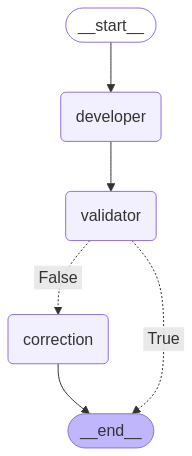

[HumanMessage(content='**Business Requirement Document**\n\n### **Introduction**\nThis document outlines the key business requirements for data management, AI model deployment, and cloud services integration. The primary focus is to ensure seamless data handling, model training, and inferencing to support AI-driven decision-making processes.\n\n### **Business Requirements**\n\n#### **1. Data Management and Transfer**\n**Objective:** Users should be able to efficiently upload, store, and retrieve image and dataset files for AI training and inferencing.\n- Users should have an intuitive interface to upload training datasets stored locally or on external drives.\n- The uploaded data should automatically be structured according to AI model requirements.\n- Users should receive clear messages regarding data errors, such as unsupported file formats, incomplete datasets, or storage issues.\n- Users should be able to retrieve DICOM images and reports from PACS servers by specifying a valid Pat

In [7]:
thread = {"configurable": {"thread_id": "1"}}
from langgraph.checkpoint.sqlite import SqliteSaver
with SqliteSaver.from_conn_string(":memory:") as checkpointer:
    abot = Agent(model, system_developer=report_generator_prompt, system_validator=report_validator_prompt, system_corrector=report_corrector_prompt,checkpointer=checkpointer)    
    for event in abot.graph.stream({"messages": messages},thread):
            for v in event.values():
                print(v['messages'][0].content)